**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4029 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 7**
Análisis de Componentes Principales (PCA)

---

| NOMBRE | MATRÍCULA  |
|--------|------------|
| Carlos Avila Arguello | A01796133 |
| Carlos Pano Hernández | A01066264 |
| Hiram Garcia Austria | A00378771 |
| Javier Emmanuel García Escobedo | A01411206|

In [1]:
import os
DIR = "./"
os.chdir(DIR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [56]:
# Regla de Scott para calcular el número de intervalos (bins) en un histograma
def scott_rule(data):
    n = len(data)
    sigma = np.std(data)
    bin_width = 3.5 * sigma / np.cbrt(n)
    k = (np.max(data) - np.min(data)) / bin_width
    return int(np.ceil(k))

In [3]:
cereals_df = pd.read_csv('Cereals.csv')
cereals_df

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8.0,NaN,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3.0,60.0,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12.0,25.0,25,2,1.0,1.00,27.753301
74,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3.0,115.0,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3.0,110.0,25,1,1.0,1.00,51.592193


# **Parte 1**. EDA y preprocesamiento

1. Obtén estadísticas descriptivas para todas las variables del dataframe. 

In [7]:
# Estadísticas descriptivas de las variables numéricas
cereals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
calories,77.0,106.883117,19.484119,50.000000,100.000000,110.000000,110.000000,160.000000
protein,77.0,2.545455,1.094790,1.000000,2.000000,3.000000,3.000000,6.000000
fat,77.0,1.012987,1.006473,0.000000,0.000000,1.000000,2.000000,5.000000
sodium,77.0,159.675325,83.832295,0.000000,130.000000,180.000000,210.000000,320.000000
fiber,77.0,2.151948,2.383364,0.000000,1.000000,2.000000,3.000000,14.000000
carbo,76.0,14.802632,3.907326,5.000000,12.000000,14.500000,17.000000,23.000000
sugars,76.0,7.026316,4.378656,0.000000,3.000000,7.000000,11.000000,15.000000
potass,75.0,98.666667,70.410636,15.000000,42.500000,90.000000,120.000000,330.000000
vitamins,77.0,28.246753,22.342523,0.000000,25.000000,25.000000,25.000000,100.000000
shelf,77.0,2.207792,0.832524,1.000000,1.000000,2.000000,3.000000,3.000000


In [8]:
# Estadísticas descriptivas de las variables categóricas
cereals_df.describe(include='object').T

,count,unique,top,freq
name,77,77,100%_Bran,1
mfr,77,7,K,23
type,77,2,C,74


Genera algunos gráficos para familiarizarte con el conjunto de datos. Al menos deberás incluir los que te permitan responder los siguientes cuestionamientos:

**Nota.** Debes responder de manera explícita las preguntas, apoyándote de los resultados observados de cada gráfico. 

2a) ¿Cuál es la frecuencia o conteo de cada categoría para las variables: `mfr` y `shelf` (por separado)? 

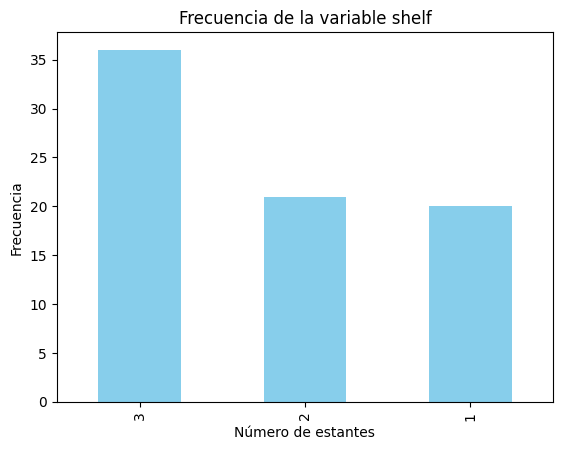

In [15]:
# Frecuencia de la variable 'shelf'
frecuencia_shelf = cereals_df['shelf'].value_counts()

# Gráfico de barras de la variable 'shelf'
frecuencia_shelf.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de la variable shelf')
plt.xlabel('Número de estantes')
plt.ylabel('Frecuencia')
plt.show()


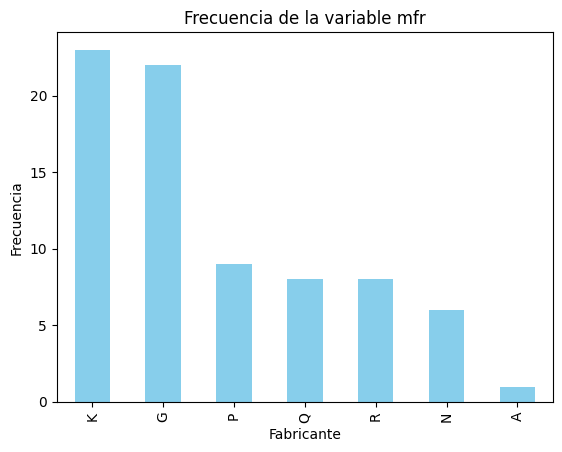

In [16]:
# Frecuencia de la variable 'mfr'
frecuencia_mfr = cereals_df['mfr'].value_counts()

# Gráfico de barras de la variable 'mfr'
frecuencia_mfr.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de la variable mfr')
plt.xlabel('Fabricante')
plt.ylabel('Frecuencia')
plt.show()

2b) Combina los resultados previos para observar, de cada fabricante, cuántos productos tiene en cada estante. 

In [25]:
# Combinacion de las variables 'shelf' y 'mfr'
combinacion_shelf_mfr = pd.crosstab(cereals_df['mfr'], cereals_df['shelf'])
combinacion_shelf_mfr

shelf,1,2,3
mfr,,,
A,0,1,0
G,6,7,9
K,4,7,12
N,3,2,1
P,2,1,6
Q,1,3,4
R,4,0,4


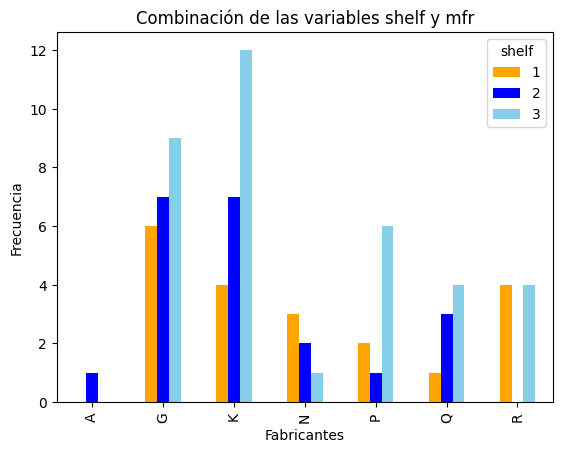

In [53]:
# Gráfico de barras de la combinación de las variables 'shelf' y 'mfr'
combinacion_shelf_mfr.plot(kind='bar', color=['orange', 'blue', 'skyblue'])
plt.title('Combinación de las variables shelf y mfr')
plt.xlabel('Fabricantes')
plt.ylabel('Frecuencia')
plt.show()

 3a) ¿Cuál es el rango más frecuente de la variable `rating`?

Número de intervalos: 7


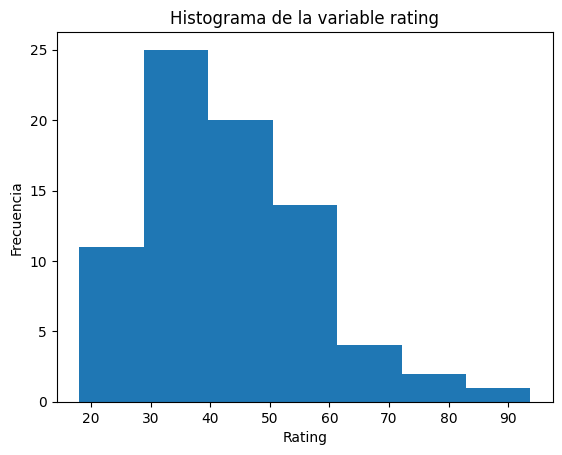

In [71]:
# Cálculo del número de intervalos para el histograma
rating_bins = scott_rule(cereals_df['rating'])

print('Número de intervalos:', rating_bins)

# Histograma de la variable 'rating'
rating_histograma = plt.hist(cereals_df['rating'], bins=rating_bins)
plt.title('Histograma de la variable rating')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

In [80]:
# Verificando los valores de los intervalos (segundo valor de la tupla)
rating_histograma

(array([11., 25., 20., 14.,  4.,  2.,  1.]),
 array([18.042851  , 28.85171686, 39.66058271, 50.46944857, 61.27831443,
        72.08718029, 82.89604614, 93.704912  ]),
 <BarContainer object of 7 artists>)

El histograma nos muestra que el segundo rango es el que tiene mayor frecuencia, y al ver los limites de los rangos tenemos que los limites del segundo rango son: 28.85171686 y 39.66058271.

3b) ¿Cuáles son los 10 cereales mejor evaluados y a qué fabricante corresponden? 

4a) Compara la distribución de las calorías según el fabricante, por medio de boxplots. 

4b) ¿Cuáles son las dos variables que tienen mayor correlación con `rating`? 

5. Elimina todos los registros con algún dato faltante y reinicia el índice del dataframe para que quede con valores consecutivos. 

# **Parte 2**. Ingeniería de características

6. Considerando que `rating` es la variable de salida, almacénala en una variable `y` y separa los predictores **numéricos** en `X`. Escala los valores de `X` y aplica `PCA` para proyectar los datos en el nuevo espacio de vectores. 

7. Obtén la curva del porcentaje de varianza acumulada y determine el número mínimo de componentes principales que explique más del 90% de la varianza. Imprime la información de dichos componentes. 

8. ¿Cuáles son las tres variables más importantes en el cálculo del primer componente?


9. ¿Todas las variables categóricas son predictores? Aplica una técnica de encoding a las que sí lo sean. Justifica la elección de tu técnica. 

10. Conjunta, en un dataframe, las valores proyectados en los componentes seleccionados (mínimo), las transformaciones obtenidas de las variables categóricas que serán predictores y la variable de salida. Almacena el dataframe resultante en archivo. 